In [1]:
import helpers

DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"

clean_text, is_depression = helpers.get_data(
    datapath=DEPRESSION_PATH,
    ngram=1,
    tokenize=True,
    by_character=False,
)

depression_word = list(zip(clean_text, is_depression))

train, dev, test = helpers.split(depression_word, dist=TDT_SPLIT)
helpers.get_stats(train)
helpers.get_stats(dev)
helpers.get_stats(test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seanx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\seanx\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seanx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Completing 80/10/10 split
Number of lines: 6184
Number of tokens: 222933
Number of unique tokens: 16656
Number of YES depression entries: 3067 (49.60%)
Number of NOT depression entries: 3117 (50.40%)
Number of lines: 773
Number of tokens: 27496
Number of unique tokens: 5050
Number of YES depression entries: 392 (50.71%)
Number of NOT depression entries: 381 (49.29%)
Number of lines: 774
Number of tokens: 27641
Number of unique tokens: 4976
Number of YES depression entries: 372 (48.06%)
Number of NOT depression entries: 402 (51.94%)


In [2]:
import math
import numpy as np
from multinomial_nb import MultinomialNaiveBayes
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    average_precision_score,
    roc_auc_score
)

train_data = train
dev_data = dev
test_data = test


def nb_pos_probs(model: MultinomialNaiveBayes, data):
    scores = []
    for tokens, _ in data:
        s0 = model.log_class_priors[0] + model._log_prob_doc_given_class(tokens, 0)
        s1 = model.log_class_priors[1] + model._log_prob_doc_given_class(tokens, 1)

        m = max(s0, s1)
        e0 = math.exp(s0 - m)
        e1 = math.exp(s1 - m)
        p1 = e1 / (e0 + e1)
        scores.append(p1)
    return np.array(scores)


nb_model = MultinomialNaiveBayes(alpha=1.0)
nb_model.fit(train_data)

y_test = np.array([label for _, label in test_data])
y_test_pred = np.array([nb_model.predict_one(tokens) for tokens, _ in test_data])

y_test_scores = nb_pos_probs(nb_model, test_data)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test,
    y_test_pred,
    average="binary",
    pos_label=1,
)

accuracy = accuracy_score(y_test, y_test_pred)
pr_auc = average_precision_score(y_test, y_test_scores)
roc_auc = roc_auc_score(y_test, y_test_scores)

print("=== Naive Bayes - Test Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

row = ["naive_bayes", precision, recall, f1, accuracy, pr_auc, roc_auc]
helpers.save_to_csv("results/results.csv", row)

=== Naive Bayes - Test Metrics ===
Precision: 0.9129
Recall: 0.8737
F1 score: 0.8929
Accuracy: 0.8992
PR AUC: 0.9598
ROC AUC: 0.9462
Data appended to results/results.csv


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    roc_curve
)

results_dir = "results/naive_bayes"
os.makedirs(results_dir, exist_ok=True)

# Confusion Matrix (Test)
cm = confusion_matrix(y_test, y_test_pred)
fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax_cm, cmap="Blues", colorbar=False)
ax_cm.set_title("Naive Bayes - Test Confusion Matrix")
plt.tight_layout()

cm_path = os.path.join(results_dir, "confusion_naive_bayes.png")
plt.savefig(cm_path, dpi=200)
plt.close(fig_cm)
print("Saved confusion matrix to:", cm_path)

# Precision-Recall Curve (Test)
fig_pr, ax_pr = plt.subplots(figsize=(5, 4))
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_scores,
    name="Naive Bayes",
    ax=ax_pr
)
ax_pr.set_title("Naive Bayes - Precision-Recall Curve (Test)")
plt.tight_layout()

pr_path = os.path.join(results_dir, "pr_naive_bayes.png")
plt.savefig(pr_path, dpi=200)
plt.close(fig_pr)
print("Saved PR curve to:", pr_path)

# ROC Curve (Test)
fpr, tpr, _ = roc_curve(y_test, y_test_scores)
fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Naive Bayes").plot(ax=ax_roc)
ax_roc.set_title("Naive Bayes - ROC Curve (Test)")
plt.tight_layout()

roc_path = os.path.join(results_dir, "roc_naive_bayes.png")
plt.savefig(roc_path, dpi=200)
plt.close(fig_roc)
print("Saved ROC curve to:", roc_path)

Saved confusion matrix to: results/naive_bayes\confusion_naive_bayes.png
Saved PR curve to: results/naive_bayes\pr_naive_bayes.png
Saved ROC curve to: results/naive_bayes\roc_naive_bayes.png


C:\Users\seanx\IdeaProjects\nlp-final-project\.venv\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


In [4]:
# Learning Curve (Test)

fractions = [0.1, 0.3, 0.5, 0.7, 1.0]

sizes = sorted({max(1, int(len(train_data) * f)) for f in fractions})

dev_accuracies = []

print("=== Naive Bayes Learning Curve ===")
for size in sizes:
    sub_train = train_data[:size]
    m = MultinomialNaiveBayes(alpha=1.0)
    m.fit(sub_train)
    acc = m.score(dev_data)
    dev_accuracies.append(acc)
    print(f"Train size {size}: dev accuracy= {acc:.4f}")

fig_lc, ax_lc = plt.subplots(figsize=(6, 4))
ax_lc.plot(sizes, dev_accuracies, marker="o")
ax_lc.set_xlabel("Number of training examples")
ax_lc.set_ylabel("Dev accuracy")
ax_lc.set_title("Naive Bayes - Learning Curve")
ax_lc.grid(True)
plt.tight_layout()

lc_path = os.path.join(results_dir, "learning_curve_naive_bayes.png")
plt.savefig(lc_path, dpi=200)
plt.close(fig_lc)

print("Saved learning curve to:", lc_path)


=== Naive Bayes Learning Curve ===
Train size 618: dev accuracy= 0.8473
Train size 1855: dev accuracy= 0.8603
Train size 3092: dev accuracy= 0.8745
Train size 4328: dev accuracy= 0.8810
Train size 6184: dev accuracy= 0.8926
Saved learning curve to: results/naive_bayes\learning_curve_naive_bayes.png


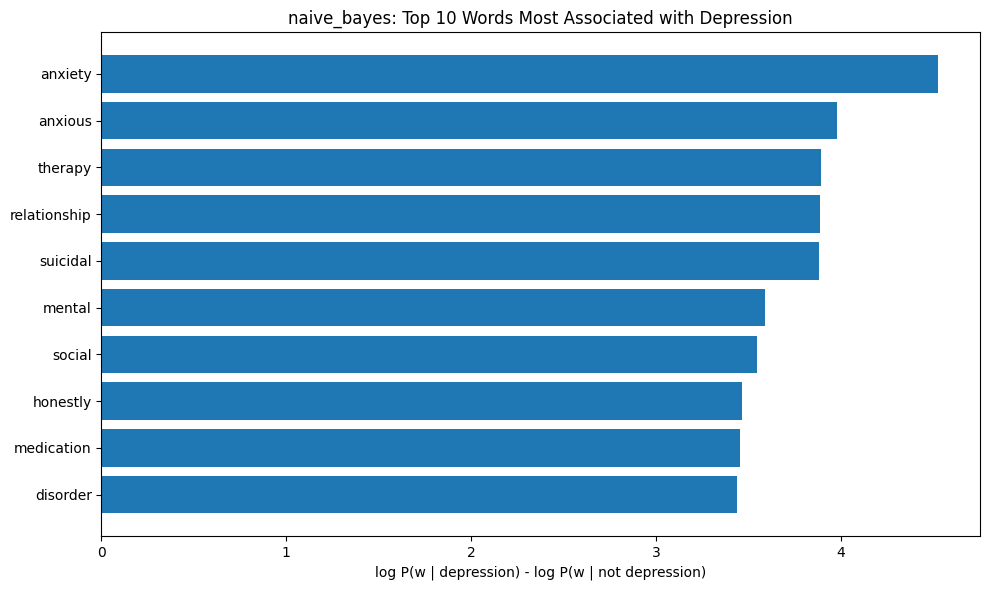

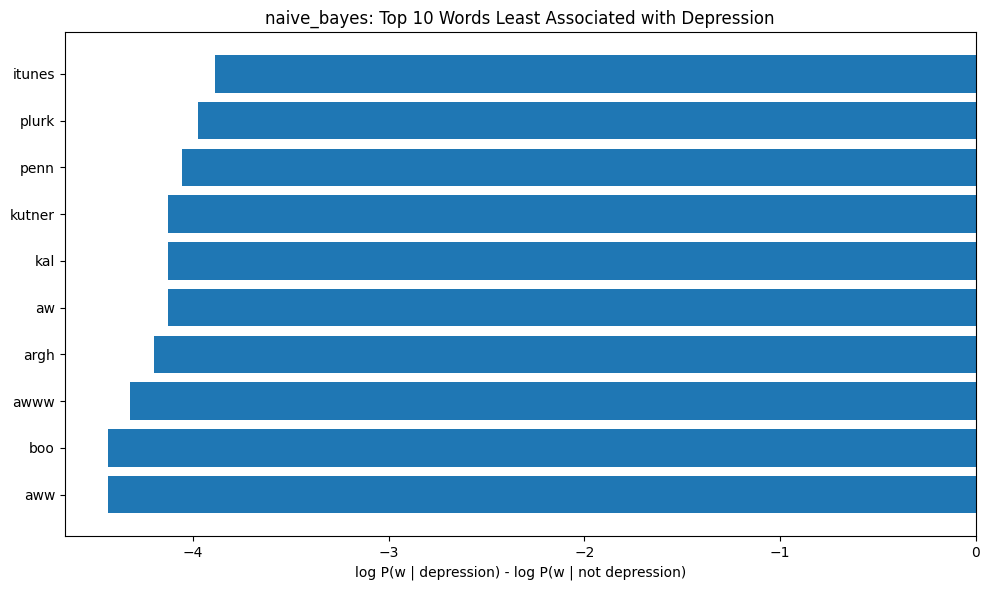

In [5]:
# Most/Least Confident Examples

vocab = list(nb_model.vocab)
V = len(vocab)

scores = []
for w in vocab:
    c0 = nb_model.token_counts[0].get(w, 0)
    c1 = nb_model.token_counts[1].get(w, 0)

    denom0 = nb_model._class_denominators[0]
    denom1 = nb_model._class_denominators[1]

    p0 = (c0 + nb_model.alpha) / denom0
    p1 = (c1 + nb_model.alpha) / denom1

    score = math.log(p1) - math.log(p0)
    scores.append(score)

scores = np.array(scores)

top_k = 10
top_indices = scores.argsort()[-top_k:]
top_words = [vocab[i] for i in top_indices]
top_values = scores[top_indices]

bottom_indices = scores.argsort()[:top_k]
bottom_words = [vocab[i] for i in bottom_indices]
bottom_values = scores[bottom_indices]

top_pairs = sorted(zip(top_values, top_words))  # ascending by value
top_vals = [v for v, w in top_pairs]
top_lbls = [w for v, w in top_pairs]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), top_vals)
plt.yticks(range(top_k), top_lbls)
plt.xlabel("log P(w | depression) - log P(w | not depression)")
plt.title("naive_bayes: Top 10 Words Most Associated with Depression")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "most_nb.png"))
plt.show()

bottom_pairs = sorted(zip(bottom_values, bottom_words))  # still ascending (most negative at top)
bottom_vals = [v for v, w in bottom_pairs]
bottom_lbls = [w for v, w in bottom_pairs]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), bottom_vals)
plt.yticks(range(top_k), bottom_lbls)
plt.xlabel("log P(w | depression) - log P(w | not depression)")
plt.title("naive_bayes: Top 10 Words Least Associated with Depression")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "least_nb.png"))
plt.show()